In [1]:
# the aim of this notebook is to illustrate the use of the Arc2kmTM tidal model, used py pyTMD
# and to provide a short, minimalistic example of how to use pyTMD
# note that if you want to use another of the models supported by pyTMD, you may need to do small changes to the code
# see in particular for help:
# (tide): https://github.com/tsutterley/pyTMD/blob/main/notebooks/Plot%20Tide%20Forecasts.ipynb
# (currents): https://github.com/tsutterley/pyTMD/blob/main/notebooks/Plot%20Antarctic%20Tidal%20Currents.ipynb
# see the Arc2kmTM_README_v1.pdf document, Arc2kmTM: Model Summary, for units

In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

import pyTMD.io
import pyTMD.time
import pyTMD.utilities
import pyTMD.predict

import os
import time

import xarray as xr
import pandas as pd
import netCDF4 as nc4

In [3]:
# my pyTMD version, installed from conda
pyTMD.__version__

'2.0.6'

In [4]:
# BELOW IS TO PREDICT TIDE CURRENT

In [5]:
# parameters for the prediction

# location: lat and lon
# can be either a single value each, or 2 np arrays (lat1, lat2, ...) and (lon1, lon2, ...) so that (lat1, lon1), (lat2, lon2), ... are the positions of interest
# --
# the same location as the in-situ observation (see below)
lat_to_predict = 72.502
lon_to_predict = 19.560

# time: either a single datetime, or a np array of datetimes
# the same time as the observation (see below)
start_day_to_predict = datetime.datetime(2008, 7, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)
number_of_hours_to_predict = 24*300
times_to_predict = [start_day_to_predict + datetime.timedelta(hours=hr) for hr in range(number_of_hours_to_predict)]

# details about the model location and format on my disk
model_path = "/home/jrmet/Desktop/Data/tides/resource_map_doi_10_18739_A2D21RK6K/"  # obtained from https://arcticdata.io/catalog/view/doi:10.18739/A2D21RK6K
model_name = "Arc2kmTM"
model_is_compressed = False
model_atlas = "netcdf"

In [6]:
# illustrate how the input model files look like
# this is simply the un-zipping of the arcticdata model data

%ls $model_path
print("---")
%ls $model_path/$model_name

Arc2kmTM/     bagit.txt         metadata/
bag-info.txt  manifest-md5.txt  tagmanifest-md5.txt
---
Arc2kmTM_FileFormat.pdf  h_Arc2kmTM_v1         UV_Arc2kmTM_v1
Arc2kmTM_README_v1.pdf   Model_Arc2kmTM_v1     xy_ll_Arc2kmTM.m
grid_Arc2kmTM_v1         Revision_history.txt


In [7]:
# note that pytmd internally uses its own time system with a given epoch start - dont mess it up and make sure to convert to it :)
pytmd_times_to_predict = [pyTMD.time.convert_calendar_dates(crrt_time.year, crrt_time.month, crrt_time.day, crrt_time.hour, crrt_time.minute, crrt_time.second) for crrt_time in times_to_predict]
model_time_delta = np.zeros_like(pytmd_times_to_predict)

In [8]:
# show how to also get currents at the same location
# inspired from https://github.com/tsutterley/pyTMD/blob/main/notebooks/Plot%20Antarctic%20Tidal%20Currents.ipynb
# note that you may need to adapt the code if using a different model
# note that we repeat some code from above for clarity
# note that this looks very similar to what was obtained above, but this is not strictly identical! (as expected,
# tide elevations and currents are in different phases). See the generated complex phases and constituents.

tide_model_base = pyTMD.io.model(
    model_path,
    format=model_atlas,
    compressed=model_is_compressed,
)

current_model = tide_model_base.current(model_name)
# current_model.type is type ['u', 'v'], i.e. BOTH u and v components of the current need to be retrieved

tide_amplitude = {}
tide_phase = {}
model_bathymetry = {}
tide_constituents = {}
tide_complex_phase = {}
tide_constituent_oscillation = {}

for type in current_model.type:
    tide_amplitude[type], tide_phase[type], model_bathymetry[type], tide_constituents[type] = pyTMD.io.OTIS.extract_constants(
        np.atleast_1d(lon_to_predict),
        np.atleast_1d(lat_to_predict),
        current_model.grid_file,
        current_model.model_file['u'],
        current_model.projection,
        type=type,
        method='spline',
        grid=current_model.format
    )
    
    tide_complex_phase[type] = -1j * tide_phase[type] * np.pi / 180.0
    tide_constituent_oscillation[type] = tide_amplitude[type] * np.exp(tide_complex_phase[type])

In [9]:
# actually perform the prediction
# as long as the location is not changed, this can be used many times to predict for different times

# this is to predict a time series at a single location over many times; for more alternatives, for example predict a map at a single times for many locations, see map in
# https://github.com/tsutterley/pyTMD/blob/main/pyTMD/predict.py

tide_current_major = {}
tide_current_minor = {}
tide_current = {}

for type in current_model.type:
    tide_current_major[type] = pyTMD.predict.time_series(
        np.atleast_1d(pytmd_times_to_predict),
        tide_constituent_oscillation[type],
        tide_constituents[type],
        #detlat=0,  # this is true for the present model, but maybe not for all of them!
        corrections=current_model.format
    )
    
    tide_current_minor[type] = pyTMD.predict.infer_minor(
        np.atleast_1d(pytmd_times_to_predict),
        tide_constituent_oscillation[type],
        tide_constituents[type],
        #detlat=0,  # this is true for the present model, but maybe not for all of them!
        corrections=current_model.format
    )
    
    tide_current[type] = tide_current_major[type] + tide_current_minor[type]

In [10]:
tide_current

{'u': masked_array(data=[14.585549313940035, 9.421235878278702,
                    2.4450647398058365, ..., -17.748034568858703,
                    -11.424931491118116, -2.1466757710907207],
              mask=[False, False, False, ..., False, False, False],
        fill_value=1e+20),
 'v': masked_array(data=[-2.934323184852216, -6.42188455361907,
                    -8.794020381224104, ..., 2.4438061903377926,
                    5.909640272467249, 8.295701013971106],
              mask=[False, False, False, ..., False, False, False],
        fill_value=1e+20)}

In [11]:
# validate against the data from:
# https://www.nature.com/articles/s41597-020-00578-z/tables/2
# available at:
# https://arcticdata.io/catalog/view/doi:10.18739/A26M3340D
# we use the dataset for validation (from List_of_records.txt):
# bar_BSO3_a_rcm7_2008_09.nc
# note that by choosing the "unhide nested data", you can download files independently, instead of downloading a huge zip of all the files
# downloading 1 file independently is very recommended (I tried to download the huge zip, but it got corrupted and could not be extracted
# on each of my attempts)

# get the file
!wget https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3Ad5f179a3-76a8-4e4f-b45f-8e8d85960ba6
# rename the file
!mv urn\:uuid\:d5f179a3-76a8-4e4f-b45f-8e8d85960ba6 bar_BSO3_a_rcm7_2008_09.nc

--2023-08-17 12:58:27--  https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3Ad5f179a3-76a8-4e4f-b45f-8e8d85960ba6
Resolving arcticdata.io (arcticdata.io)... 128.111.85.224
Connecting to arcticdata.io (arcticdata.io)|128.111.85.224|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/netcdf]
Saving to: ‘urn:uuid:d5f179a3-76a8-4e4f-b45f-8e8d85960ba6’

urn:uuid:d5f179a3-7     [    <=>             ]   1,21M  1,12MB/s    in 1,1s    

2023-08-17 12:58:29 (1,12 MB/s) - ‘urn:uuid:d5f179a3-76a8-4e4f-b45f-8e8d85960ba6’ saved [1264327]



In [12]:
xr_obs = xr.open_dataset("./bar_BSO3_a_rcm7_2008_09.nc", drop_variables=["six_con", "all_con"])

In [13]:
# where on the Earth we are getting data
print(f"{float(xr_obs.latitude.data) = }")
print(f"{float(xr_obs.longitude.data) = }")

# when we are getting data
print(f"{xr_obs.time[0].data = }")
print(f"{xr_obs.time[-1].data = }")

float(xr_obs.latitude.data) = 72.502
float(xr_obs.longitude.data) = 19.560833333333335
xr_obs.time[0].data = array('2008-06-27T23:00:00.000003000', dtype='datetime64[ns]')
xr_obs.time[-1].data = array('2009-06-29T08:20:00.000002000', dtype='datetime64[ns]')


In [14]:
xr_obs_pd_timestamp = pd.to_datetime([pd.Timestamp(timestamp) for timestamp in xr_obs["time"].data], utc=True)

In [15]:
df_xr_obs = pd.DataFrame({'utc_timestamp':xr_obs_pd_timestamp, 'xr_obs_u':xr_obs["u_tide_pred"].squeeze(), 'xr_obs_v':xr_obs["v_tide_pred"].squeeze()})

In [16]:
df_pytmd = pd.DataFrame({'utc_timestamp':times_to_predict, 'pytmd_u':tide_current["u"], 'pytmd_v':tide_current["v"]})

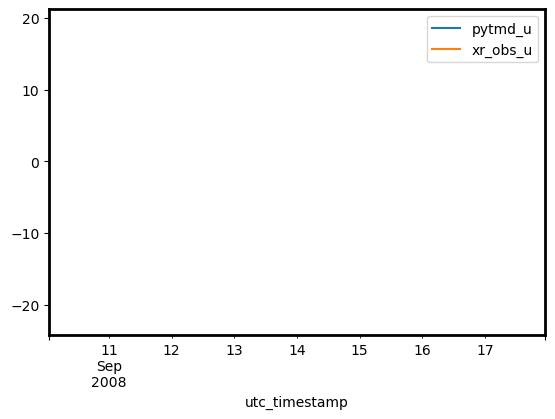

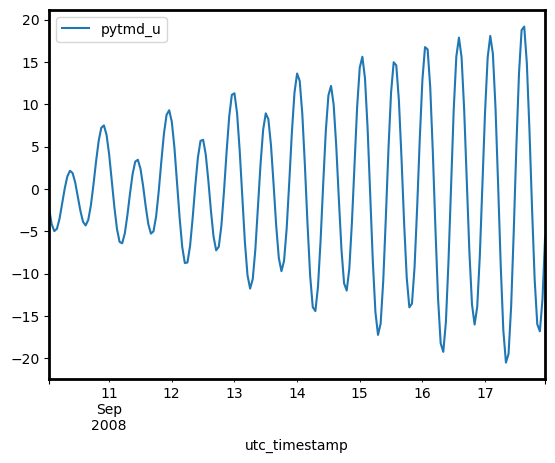

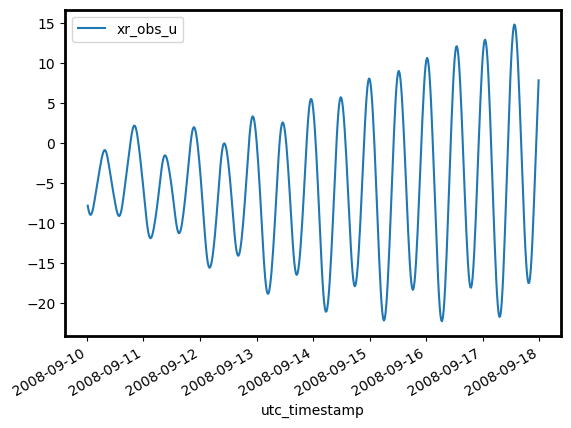

In [17]:
# compare the model data generated by pyTMD to the observations-based full record tidal analysis

# time window to plot for comparison
utc_timestamp_start = datetime.datetime(2008, 9, 10, 0, 0, 0, tzinfo=datetime.timezone.utc)
utc_timestamp_stop = datetime.datetime(2008, 9, 18, 0, 0, 0, tzinfo=datetime.timezone.utc)

def get_mask(df_in, utc_timestamp_start, utc_timestamp_stop):
    mask = (df_in["utc_timestamp"] > utc_timestamp_start) & (df_in["utc_timestamp"] < utc_timestamp_stop) 
    return mask

# plotting...

# keeping this for now, to report issue to pandas

# this should work but plot is empty!
fig = plt.figure()
ax = plt.gca()
#
mask_pytmd = get_mask(df_pytmd, utc_timestamp_start, utc_timestamp_stop)
df_pytmd.loc[mask_pytmd].plot(x="utc_timestamp", y="pytmd_u", ax=ax)
#
mask_xr_obs = get_mask(df_xr_obs, utc_timestamp_start, utc_timestamp_stop)
df_xr_obs.loc[mask_xr_obs].plot(x="utc_timestamp", y=["xr_obs_u"], ax=ax)
#
plt.show()

# while both plots individually work

# plot 1
fig = plt.figure()
ax = plt.gca()
#
mask_pytmd = get_mask(df_pytmd, utc_timestamp_start, utc_timestamp_stop)
df_pytmd.loc[mask_pytmd].plot(x="utc_timestamp", y="pytmd_u", ax=ax)
#
# mask_xr_obs = get_mask(df_xr_obs, utc_timestamp_start, utc_timestamp_stop)
# df_xr_obs.loc[mask_xr_obs].plot(x="utc_timestamp", y=["xr_obs_u"], ax=ax)
#
plt.show()

# plot 2
fig = plt.figure()
ax = plt.gca()
#
# mask_pytmd = get_mask(df_pytmd, utc_timestamp_start, utc_timestamp_stop)
# df_pytmd.loc[mask_pytmd].plot(x="utc_timestamp", y="pytmd_u", ax=ax)
#
mask_xr_obs = get_mask(df_xr_obs, utc_timestamp_start, utc_timestamp_stop)
df_xr_obs.loc[mask_xr_obs].plot(x="utc_timestamp", y=["xr_obs_u"], ax=ax)
#
plt.show()

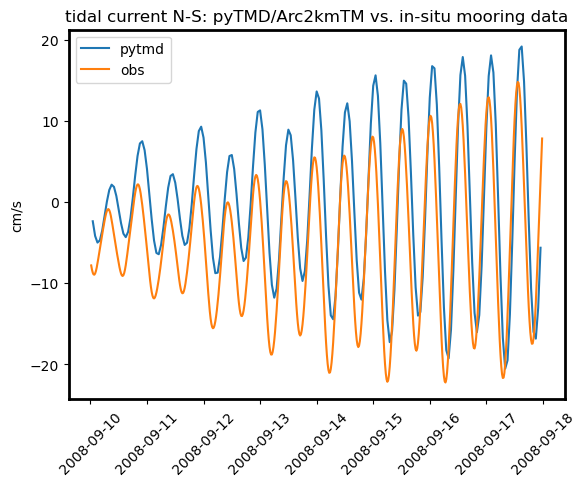

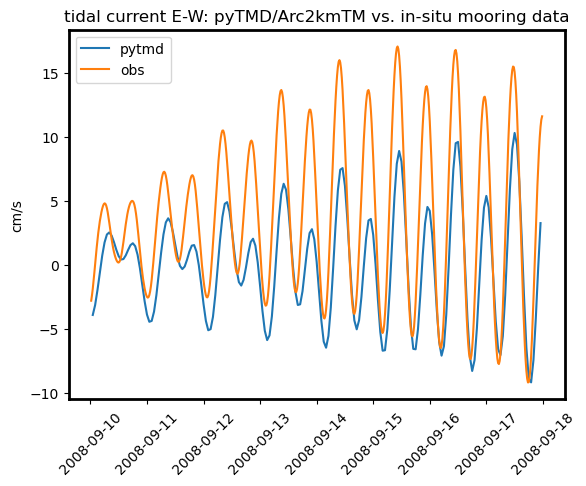

In [18]:
# plot by hand instead
timestamp_pytmd = df_pytmd.loc[mask_pytmd]["utc_timestamp"].values
timestamp_xr_obs = df_xr_obs.loc[mask_xr_obs]["utc_timestamp"].values

u_pytmd = df_pytmd.loc[mask_pytmd]["pytmd_u"].values
u_xr_obs = df_xr_obs.loc[mask_xr_obs]["xr_obs_u"].values

v_pytmd = df_pytmd.loc[mask_pytmd]["pytmd_v"].values
v_xr_obs = df_xr_obs.loc[mask_xr_obs]["xr_obs_v"].values

plt.figure()
plt.plot(timestamp_pytmd, u_pytmd, label="pytmd")
plt.plot(timestamp_xr_obs, u_xr_obs, label="obs")
plt.xticks(rotation=45)
plt.ylabel("cm/s")
plt.legend()
plt.title("tidal current N-S: pyTMD/Arc2kmTM vs. in-situ mooring data")
plt.show()

plt.figure()
plt.plot(timestamp_pytmd, v_pytmd, label="pytmd")
plt.plot(timestamp_xr_obs, v_xr_obs, label="obs")
plt.xticks(rotation=45)
plt.ylabel("cm/s")
plt.title("tidal current E-W: pyTMD/Arc2kmTM vs. in-situ mooring data")
plt.legend()
plt.show()

In [19]:
# a bit underestimated, but not so bad for a global model!